## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [7]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.3, 0.5, 0.7]
redice_lr_patient = [5, 10]

In [9]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                                  min_lr=1e-12, 
                                  monitor='val_loss', 
                                  patience=reduce_patient, 
                                  verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}

Numbers of exp: 0, reduce_factor: 0.30, reduce_patient: 5
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_4 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_5 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
b

Epoch 11/25
50000/50000 [==============================] - 2s 45us/step - loss: 1.5016 - accuracy: 0.4771 - val_loss: 1.6137 - val_accuracy: 0.4313
Epoch 12/25
50000/50000 [==============================] - 2s 45us/step - loss: 1.4808 - accuracy: 0.4857 - val_loss: 1.6016 - val_accuracy: 0.4375
Epoch 13/25
50000/50000 [==============================] - 2s 45us/step - loss: 1.4613 - accuracy: 0.4908 - val_loss: 1.5978 - val_accuracy: 0.4402
Epoch 14/25
50000/50000 [==============================] - 2s 45us/step - loss: 1.4430 - accuracy: 0.4974 - val_loss: 1.5884 - val_accuracy: 0.4389
Epoch 15/25
50000/50000 [==============================] - 2s 46us/step - loss: 1.4276 - accuracy: 0.5033 - val_loss: 1.5873 - val_accuracy: 0.4413
Epoch 16/25
50000/50000 [==============================] - 2s 45us/step - loss: 1.4114 - accuracy: 0.5096 - val_loss: 1.5766 - val_accuracy: 0.4420
Epoch 17/25
50000/50000 [==============================] - 2s 44us/step - loss: 1.3956 - accuracy: 0.5149 - val_

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 3s 55us/step - loss: 2.4690 - accuracy: 0.2061 - val_loss: 2.2028 - val_accuracy: 0.1691
Epoch 2/25
50000/50000 [==============================] - 2s 44us/step - loss: 1.9785 - accuracy: 0.3206 - val_loss: 2.0448 - val_accuracy: 0.2599
Epoch 3/25
50000/50000 [==============================] - 2s 44us/step - loss: 1.8184 - accuracy: 0.3669 - val_loss: 1.9315 - val_accuracy: 0.3081
Epoch 4/25
50000/50000 [==============================] - 2s 44us/step - loss: 1.7361 - accuracy: 0.3931 - val_loss: 1.8491 - val_accuracy: 0.3408
Epoch 5/25
50000/50000 [==============================] - 2s 44us/step - loss: 1.6805 - accuracy: 0.4135 - val_loss: 1.7850 - val_accuracy: 0.3636
Epoch 6/25
50000/50000 [==============================] - 2s 47us/step - loss: 1.6371 - accuracy: 0.4296 - val_loss: 1.7287 - val_accuracy: 0.3846
Epoch 7/25
50000/50000 [==============================] - 2s 47us/st

Epoch 21/25
50000/50000 [==============================] - 2s 45us/step - loss: 1.3542 - accuracy: 0.5335 - val_loss: 1.5475 - val_accuracy: 0.4604
Epoch 22/25
50000/50000 [==============================] - 2s 46us/step - loss: 1.3416 - accuracy: 0.5378 - val_loss: 1.5358 - val_accuracy: 0.4610
Epoch 23/25
50000/50000 [==============================] - 2s 45us/step - loss: 1.3295 - accuracy: 0.5424 - val_loss: 1.5322 - val_accuracy: 0.4621
Epoch 24/25
50000/50000 [==============================] - 2s 45us/step - loss: 1.3166 - accuracy: 0.5486 - val_loss: 1.5288 - val_accuracy: 0.4622
Epoch 25/25
50000/50000 [==============================] - 2s 46us/step - loss: 1.3048 - accuracy: 0.5506 - val_loss: 1.5244 - val_accuracy: 0.4673
Numbers of exp: 5, reduce_factor: 0.70, reduce_patient: 10
Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 3072)           

Epoch 6/25
50000/50000 [==============================] - 2s 47us/step - loss: 1.1867 - accuracy: 0.5836 - val_loss: 1.9556 - val_accuracy: 0.3454
Epoch 7/25
50000/50000 [==============================] - 2s 47us/step - loss: 1.1394 - accuracy: 0.5990 - val_loss: 2.0588 - val_accuracy: 0.3148

Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 8/25
50000/50000 [==============================] - 2s 47us/step - loss: 1.0277 - accuracy: 0.6422 - val_loss: 1.6304 - val_accuracy: 0.4265
Epoch 9/25
50000/50000 [==============================] - 2s 46us/step - loss: 0.9714 - accuracy: 0.6638 - val_loss: 1.4369 - val_accuracy: 0.4961
Epoch 10/25
50000/50000 [==============================] - 2s 47us/step - loss: 0.9401 - accuracy: 0.6760 - val_loss: 1.4436 - val_accuracy: 0.4888
Epoch 11/25
50000/50000 [==============================] - 2s 47us/step - loss: 0.9106 - accuracy: 0.6865 - val_loss: 1.4129 - val_accuracy: 0.4935
Epoch 12/25
50000/50000 [==========

50000/50000 [==============================] - 2s 46us/step - loss: 1.0097 - accuracy: 0.6676 - val_loss: 1.4422 - val_accuracy: 0.4981
Epoch 25/25
50000/50000 [==============================] - 2s 46us/step - loss: 0.9978 - accuracy: 0.6736 - val_loss: 1.4480 - val_accuracy: 0.4901
Numbers of exp: 8, reduce_factor: 0.50, reduce_patient: 5
Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_28 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
______________________________________________

Epoch 9/25
50000/50000 [==============================] - 2s 48us/step - loss: 1.2514 - accuracy: 0.5689 - val_loss: 1.4804 - val_accuracy: 0.4784
Epoch 10/25
50000/50000 [==============================] - 2s 47us/step - loss: 1.2271 - accuracy: 0.5776 - val_loss: 1.4794 - val_accuracy: 0.4754
Epoch 11/25
50000/50000 [==============================] - 2s 47us/step - loss: 1.2044 - accuracy: 0.5886 - val_loss: 1.4605 - val_accuracy: 0.4860
Epoch 12/25
50000/50000 [==============================] - 2s 49us/step - loss: 1.1821 - accuracy: 0.5951 - val_loss: 1.4686 - val_accuracy: 0.4832
Epoch 13/25
50000/50000 [==============================] - 2s 48us/step - loss: 1.1622 - accuracy: 0.6043 - val_loss: 1.4722 - val_accuracy: 0.4821
Epoch 14/25
50000/50000 [==============================] - 2s 48us/step - loss: 1.1429 - accuracy: 0.6110 - val_loss: 1.4484 - val_accuracy: 0.4935
Epoch 15/25
50000/50000 [==============================] - 2s 47us/step - loss: 1.1235 - accuracy: 0.6198 - val_l

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 3s 59us/step - loss: 2.0171 - accuracy: 0.3233 - val_loss: 2.1783 - val_accuracy: 0.2094
Epoch 2/25
50000/50000 [==============================] - 2s 47us/step - loss: 1.6533 - accuracy: 0.4260 - val_loss: 1.9638 - val_accuracy: 0.3208
Epoch 3/25
50000/50000 [==============================] - 2s 47us/step - loss: 1.5543 - accuracy: 0.4617 - val_loss: 1.8235 - val_accuracy: 0.3730
Epoch 4/25
50000/50000 [==============================] - 2s 47us/step - loss: 1.4934 - accuracy: 0.4822 - val_loss: 1.7168 - val_accuracy: 0.4060
Epoch 5/25
50000/50000 [==============================] - 2s 47us/step - loss: 1.4483 - accuracy: 0.5003 - val_loss: 1.6369 - val_accuracy: 0.4321
Epoch 6/25
50000/50000 [==============================] - 2s 47us/step - loss: 1.4109 - accuracy: 0.5131 - val_loss: 1.5858 - val_accuracy: 0.4462
Epoch 7/25
50000/50000 [==============================] - 2s 47us/st

50000/50000 [==============================] - 2s 45us/step - loss: 0.7264 - accuracy: 0.7555 - val_loss: 1.4783 - val_accuracy: 0.5074
Epoch 21/25
50000/50000 [==============================] - 2s 44us/step - loss: 0.7071 - accuracy: 0.7636 - val_loss: 1.5606 - val_accuracy: 0.4949
Epoch 22/25
50000/50000 [==============================] - 2s 45us/step - loss: 0.6853 - accuracy: 0.7721 - val_loss: 1.4674 - val_accuracy: 0.5169
Epoch 23/25
50000/50000 [==============================] - 2s 44us/step - loss: 0.6658 - accuracy: 0.7784 - val_loss: 1.6254 - val_accuracy: 0.4876
Epoch 24/25
50000/50000 [==============================] - 2s 45us/step - loss: 0.6454 - accuracy: 0.7870 - val_loss: 1.5243 - val_accuracy: 0.5083

Epoch 00024: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
Epoch 25/25
50000/50000 [==============================] - 2s 44us/step - loss: 0.5794 - accuracy: 0.8200 - val_loss: 1.4409 - val_accuracy: 0.5311
Numbers of exp: 13, reduce_factor: 0.30, re

Epoch 4/25
50000/50000 [==============================] - 2s 45us/step - loss: 1.6663 - accuracy: 0.4188 - val_loss: 1.8057 - val_accuracy: 0.3599
Epoch 5/25
50000/50000 [==============================] - 2s 44us/step - loss: 1.6030 - accuracy: 0.4408 - val_loss: 1.7418 - val_accuracy: 0.3844
Epoch 6/25
50000/50000 [==============================] - 2s 44us/step - loss: 1.5529 - accuracy: 0.4594 - val_loss: 1.6765 - val_accuracy: 0.4079
Epoch 7/25
50000/50000 [==============================] - 2s 44us/step - loss: 1.5102 - accuracy: 0.4751 - val_loss: 1.6595 - val_accuracy: 0.4061
Epoch 8/25
50000/50000 [==============================] - 2s 44us/step - loss: 1.4734 - accuracy: 0.4883 - val_loss: 1.6021 - val_accuracy: 0.4372
Epoch 9/25
50000/50000 [==============================] - 2s 44us/step - loss: 1.4404 - accuracy: 0.4997 - val_loss: 1.5903 - val_accuracy: 0.4407
Epoch 10/25
50000/50000 [==============================] - 2s 44us/step - loss: 1.4093 - accuracy: 0.5110 - val_loss: 

50000/50000 [==============================] - 2s 44us/step - loss: 1.1340 - accuracy: 0.6158 - val_loss: 1.4986 - val_accuracy: 0.4780
Epoch 25/25
50000/50000 [==============================] - 2s 44us/step - loss: 1.1208 - accuracy: 0.6191 - val_loss: 1.5051 - val_accuracy: 0.4793
Numbers of exp: 16, reduce_factor: 0.70, reduce_patient: 5
Model: "model_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_52 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_____________________________________________

Epoch 9/25
50000/50000 [==============================] - 2s 44us/step - loss: 1.4264 - accuracy: 0.5023 - val_loss: 1.5811 - val_accuracy: 0.4449
Epoch 10/25
50000/50000 [==============================] - 2s 44us/step - loss: 1.3969 - accuracy: 0.5142 - val_loss: 1.5543 - val_accuracy: 0.4546
Epoch 11/25
50000/50000 [==============================] - 2s 44us/step - loss: 1.3707 - accuracy: 0.5244 - val_loss: 1.5513 - val_accuracy: 0.4596
Epoch 12/25
50000/50000 [==============================] - 2s 44us/step - loss: 1.3458 - accuracy: 0.5330 - val_loss: 1.5531 - val_accuracy: 0.4564
Epoch 13/25
50000/50000 [==============================] - 2s 45us/step - loss: 1.3227 - accuracy: 0.5418 - val_loss: 1.5328 - val_accuracy: 0.4669
Epoch 14/25
50000/50000 [==============================] - 2s 44us/step - loss: 1.3011 - accuracy: 0.5503 - val_loss: 1.5430 - val_accuracy: 0.4636
Epoch 15/25
50000/50000 [==============================] - 2s 44us/step - loss: 1.2799 - accuracy: 0.5596 - val_l

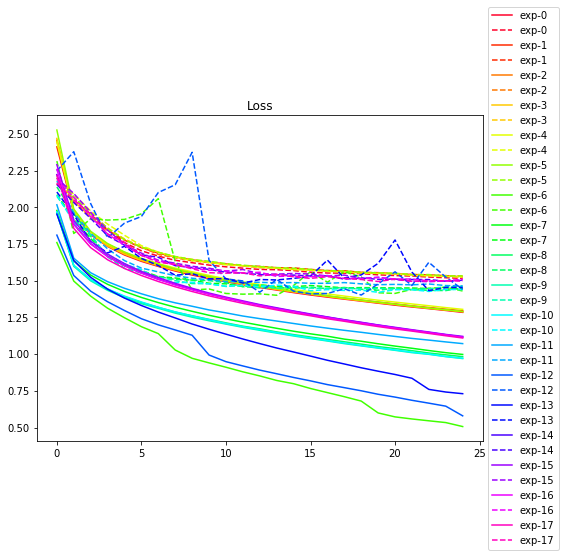

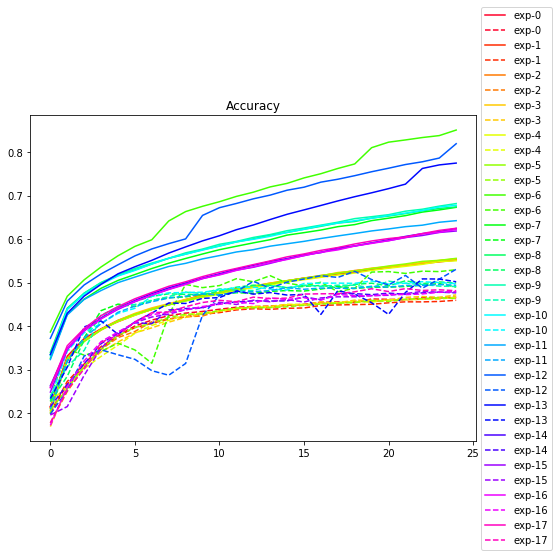

In [10]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()